In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from neuron import h
import pds_plots as ppl
import matplotlib.pyplot as plt
from pop_generation.mf_generation import Bridson_sampling_2d

h.load_file('test/set3005/Parameters.hoc')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1.0

In [173]:
h.MFxrange = 740
h.MFyrange = 740
h.GLdepth = 240


def compute_mf_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    n_mf = int((Transverse_range + (2 * Xinstantiate)) * (Horizontal_range + (2 * Yinstantiate)) * MFdensity * 1e-6)
    print('N MF = {}'.format(n_mf))
    return ((Horizontal_range, Transverse_range), n_mf)

mf_box, n_mf = compute_mf_params(h)

spacing_mf = 14.2
mf_points = Bridson_sampling_2d(mf_box, spacing_mf, n_mf, True)

N MF = 1733


Iteration: 6, (final)Points Created: 1733, is_grid_empty:8007 (81.69574533210897%)


QhullError: QH6019 qhull input error: can not scale last coordinate.  Input is cocircular
   or cospherical.   Use option 'Qz' to add a point at infinity.

While executing:  | qhull v Qbb Qc Qz
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1287072293  voronoi  Qbbound-last  Qcoplanar-keep  Qz-infinity-point
  _pre-merge  _zero-centrum  Qinterior-keep  Pgood


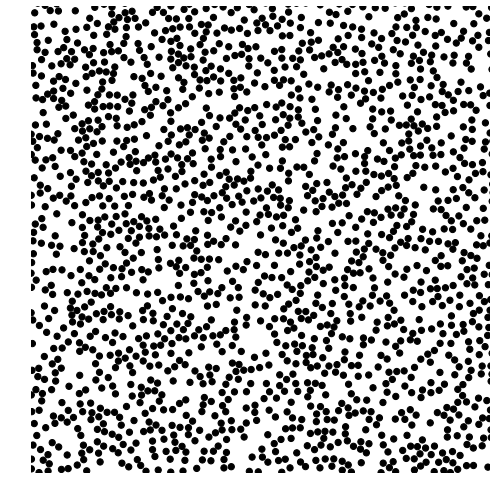

In [174]:
ppl.plot_mf_1(mf_points, mf_box, 5)
ppl.plot_mf_2(mf_points, mf_box)

In [156]:
def compute_goc_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GoCzrange + 50

    Volume = Transverse_range * Horizontal_range * Vertical_range

    d_goc = h.GoCdensity
    n_goc = int(d_goc * Volume * 1e-9)
    return ((Horizontal_range, Transverse_range, Vertical_range), n_goc)


goc_box, n_goc = compute_goc_params(h)

In [157]:
# spacing_glo = 6.6-1 #(Billings et al., 2014) Since glomeruli is elipsoid shape, I recalculated based on the spatial occupancy of glomeruli and its density. Also, I subtract 1 cuz I will give Gaussian noise
# spacing_grc = 6-1 # (Billings et al., 2014) I subtract 1 because I will give Gaussian noise

# #Density of cells (mm^-3)
# d_goc = 9500  # (Dugue GP et al., 2009)
# d_glo = 6.6 * 1e5 #(Billings et al., 2014)
# d_grc = 1.9 * 1e6 #(Billings et al., 2014)

spacing_goc = 42 #40 #(NH Barmack, V Yakhnitsa, 2008)

from pop_generation.mf_generation import Bridson_sampling_first
goc_points = Bridson_sampling_first(goc_box, spacing_goc, n_goc, True)
goc_points = goc_points + np.random.normal(0, 1, size=(len(goc_points), 3)) #Gaussian noise
goc_points = goc_points-np.array([20, 20, 20])

Iteration: 820, (final)Points Created: 1300, is_grid_empty:9272 (87.71166398637783%)


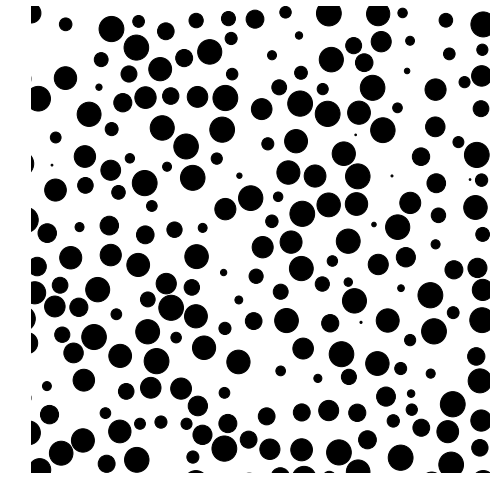

In [158]:
ppl.plot_goc(goc_points, goc_box, 0, 20)

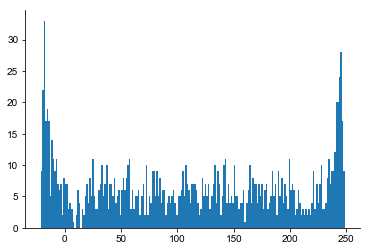

In [159]:
_ = plt.hist(goc_points[:, 2], 200)

(array([40., 81., 42., 18., 19., 14., 11.,  9., 11., 10.,  7.,  7., 13.,
        17., 11., 16., 23.,  8., 13., 21., 12., 11., 13., 11., 11., 13.,
        13., 12.,  5., 14., 18., 18., 13., 17., 16., 10., 19., 11., 15.,
        15.,  9., 12.,  9., 11., 13., 15., 32., 36., 70., 66.]),
 array([ -2.68922587,   1.45985182,   5.60892951,   9.75800719,
         13.90708488,  18.05616256,  22.20524025,  26.35431794,
         30.50339562,  34.65247331,  38.801551  ,  42.95062868,
         47.09970637,  51.24878406,  55.39786174,  59.54693943,
         63.69601712,  67.8450948 ,  71.99417249,  76.14325018,
         80.29232786,  84.44140555,  88.59048324,  92.73956092,
         96.88863861, 101.0377163 , 105.18679398, 109.33587167,
        113.48494936, 117.63402704, 121.78310473, 125.93218242,
        130.0812601 , 134.23033779, 138.37941548, 142.52849316,
        146.67757085, 150.82664853, 154.97572622, 159.12480391,
        163.27388159, 167.42295928, 171.57203697, 175.72111465,
        179.

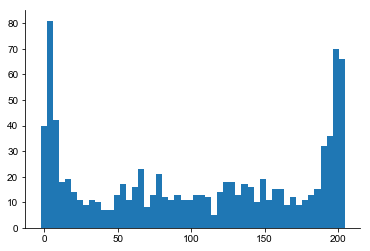

In [ ]:
print(n_goc, ' ', goc_points.shape[0])

In [ ]:
def compute_glo_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    d_glo = 6.6 * 1e5 #(Billings et al., 2014)
    n_glo = int(d_glo * Volume * 1e-9)
    print("N of Glomeruli = {}".format(n_glo))

    return ((Horizontal_range, Transverse_range//3, Vertical_range), n_glo)

#Glomerulus (Rosettes)
from pop_generation.second_generation import Bridson_sampling_second

globox, n_glo = compute_glo_params(h)
spacing_glo = 6.6-1 #(Billings et al., 2014) Since glomeruli is elipsoid shape, I recalculated based on the spatial occupancy of glomeruli and its density. Also, I subtract 1 cuz I will give Gaussian noise

glo_points = Bridson_sampling_second(globox, spacing_glo, n_glo, True, goc_points)
glo_points[:, 1] = glo_points[:, 1]*3 # Since glomerulus is stretched for Horizontal section, we will generate coordinates in small area at first, and then multiply it with 3. (Billings et al., 2014)

glo_points = glo_points+np.random.normal(0, 0.5, size=(len(glo_points), 3))

In [ ]:
glo_points[:,0].max()
glo_points[:,1].max()
glo_points[:,2].max()

In [ ]:
ppl.plot_glo(glo_points, goc_box, np.array([0, 10])+100, 2.7)

In [ ]:
ppl.plot_goc_glo((goc_points, 15), (glo_points, 2.7), goc_box, np.array([0, 5])+50)

In [ ]:
from pop_generation.third_generation import Bridson_sampling_third

def compute_grc_params(h):
    Transverse_range = h.MFyrange
    Horizontal_range = h.MFxrange
    Vertical_range = h.GLdepth
    Volume = Transverse_range * Horizontal_range * Vertical_range

    MFdensity = h.MFdensity

    box_fac = 2.5
    Xinstantiate = 64 + 40  # 297+40
    Yinstantiate = 84 + 40 * box_fac  # 474+40x*box_fac

    d_grc = 1.9 * 1e6 #(Billings et al., 2014)
    n_grc = int(d_grc * Volume * 1e-9)

    print("N of GrC = {}".format(n_grc))

    return ((Horizontal_range, Transverse_range, Vertical_range), n_grc)


spacing_grc = 6-1 # (Billings et al., 2014) I subtract 1 because I will give Gaussian noise

grcbox, n_grc = compute_grc_params(h)

grc_points = Bridson_sampling_third(grcbox, spacing_grc, n_grc, True, goc_points, glo_points)
ppl.plot_goc_glo((goc_points, 15), (glo_points, 2.7), (glo_points, 2.5), goc_box, np.array([0, 5])+50)